,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,3.0240
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0120
ada,Ada Boost Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.6680
gbc,Gradient Boosting Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,10.0060
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.3000
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1680
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.1900
et,Extra Trees Classifier,0.9994,1.0000,0.9994,0.9994,0.9994,0.9991,0.9991,1.2220
lr,Logistic Regression,0.9993,0.0000,0.9993,0.9993,0.9993,0.9990,0.9990,8.2540
lda,Linear Discriminant Analysis,0.9531,0.0000,0.9531,0.9550,0.9535,0.9296,0.9302,0.7100


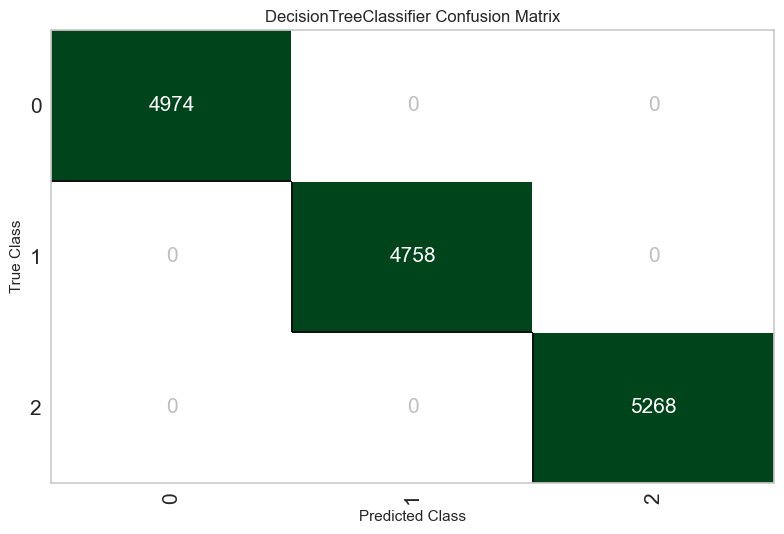

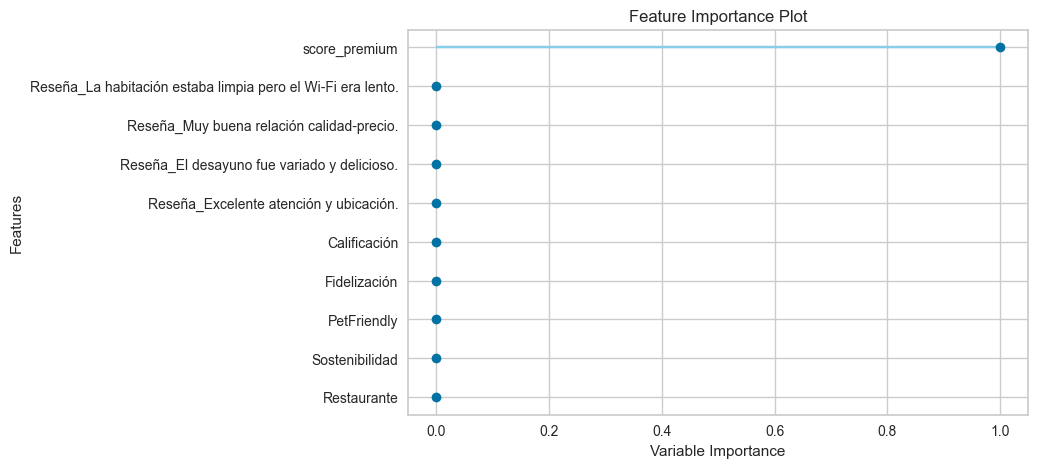

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


       Edad     Género Procedencia Tipo_viajero        Motivo_viaje  \
12149    21  Masculino      México      Familia             Turismo   
42386    25   Femenino      España        Grupo  Eventos culturales   
1115     50  Masculino      México      Familia  Eventos culturales   
18699    58  Masculino       Tunja        Grupo  Eventos culturales   
12951    27  Masculino      México       Pareja             Turismo   

          Temporada  Duración_estadía   Canal_reserva  \
12149    Vacaciones                 6          Airbnb   
42386    Vacaciones                15  Agencia física   
1115     Vacaciones                15         Booking   
18699  Semana Santa                 8  Agencia física   
12951    Vacaciones                14  Agencia física   

       Anticipación_reserva_días  Cancelación_probable  ... amenities_norm  \
12149                        132                 False  ...          0.500   
42386                         60                  True  ...          0.625

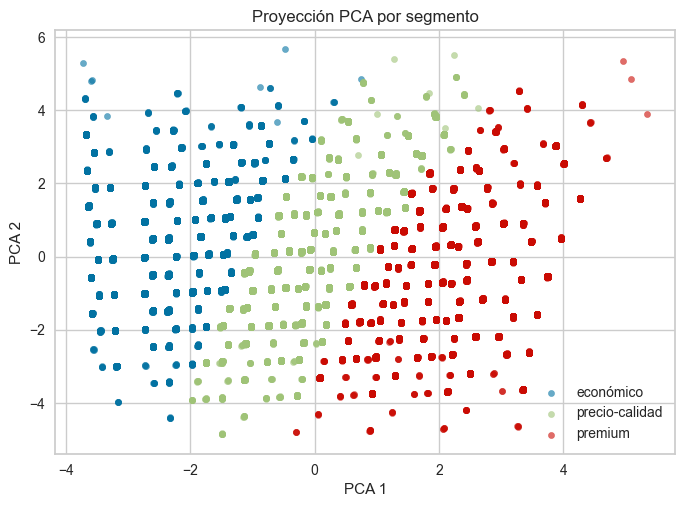

In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1) Carga el dataset con la etiqueta 'segmento' ---
ruta = r"C:\Users\FABIO\Downloads\dataset_hoteles_tunja_50000_segmentado.csv"  # <- usa el segmentado
df = pd.read_csv(ruta, encoding='utf-8-sig')

# --- 2) PyCaret (supervisado) ---
# Ignora columnas de texto libre (si las hay) para acelerar/evitar ruido
ignore = []
for c in df.columns:
    if df[c].dtype == 'object' and c not in ['segmento']:
        # Si son descripciones larguísimas, mejor ignorarlas
        if df[c].str.len().fillna(0).mean() > 40:
            ignore.append(c)

s = setup(
    data=df,
    target='segmento',
    ignore_features=ignore,
    session_id=42,
    fold=5,
    verbose=False
)

best = compare_models()
# Gráficos útiles en clasificación
plot_model(best, plot='confusion_matrix')   # matriz de confusión
plot_model(best, plot='feature')            # importancia de variables (cuando aplique)
# evaluate_model(best)  # abre panel interactivo; útil en notebook

preds = predict_model(best)
print(preds.head())

# --- 3) Visualización 2D de “agrupación” con PCA (fuera de PyCaret) ---
# Prepara X numérico (one-hot para categóricas si quieres incluirlas)
y = df['segmento']
X = df.drop(columns=['segmento']).copy()

# Convierte categóricas a dummies y rellena nulos
X = pd.get_dummies(X, drop_first=True)
X = X.select_dtypes(include='number').fillna(0.0)

# Escalado + PCA a 2 componentes
X_scaled = StandardScaler().fit_transform(X)
Z = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

# Scatter 2D coloreado por segmento
plt.figure()
for seg in ['económico','precio-calidad','premium']:
    mask = (y == seg)
    plt.scatter(Z[mask,0], Z[mask,1], label=seg, alpha=0.6, s=20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Proyección PCA por segmento')
plt.legend()
plt.show()


